In [522]:
#Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Blurring by convolutions


## (a) Implement your own convolutional mean filter with the following sizes: 3\*3, 5\*5, 9\*9 pixels (example kernels provided in the lecture).

In [523]:
from cv2 import Mat
from numpy import ndarray, shape, uint8
from enum import Enum, auto

class PaddingType(Enum):
    BLANK = auto()
    EXTEND = auto()
    MIRROR = auto()

def extend_image_borders(image: Mat, padding: PaddingType, x_extend_length: int, y_extend_length: int) -> Mat:
    """  
    Resolve the border problem of images in the scope of convolutions by extending its x,y borders by the given length.
    Only works for images with one channel (1D pixels)

    Args
    -----
        image: Mat - The original image
        padding: PaddingType - The padding type of the image
        x_extend_length: int - The number of horizontal pixels to add at the left and right of the image.
        y_extend_length: int - The number of vertical pixels to add at the top and bottom of the image.

    Returns
    -----
        A copy of the padded image, with a size of (w + 2*x_extend_length, y + 2*y_extend_length) for the pixels added on the horizontal and vertical axis.
    """
    #Transpose is usefull to work in usual (x,y) base and not (y,x) as images are encoded (2D arrays, first access line, then column)
    image = image.transpose()
    w,h = image.shape
    res_w, res_h = (w + 2*x_extend_length, h + 2*y_extend_length)

    #Create canevas
    image_copy = np.zeros(shape=(res_w, res_h), dtype=uint8)

    #Fill middle of canvas
    image_copy[x_extend_length:res_w-x_extend_length, y_extend_length:res_h-y_extend_length] = image[:,:]

    if padding == PaddingType.EXTEND:
        #Horizontal padd 
        for y in range(res_h):#For every column
            for i in range(x_extend_length):
                #Left
                image_copy[i, y] = image_copy[x_extend_length, y]
                #Right
                image_copy[w + x_extend_length + i, y] = image_copy[w-1 + x_extend_length, y]
        #vertical padd 
        for x in range(res_w):#For every column
            for j in range(y_extend_length):
                #up
                image_copy[x, j] = image_copy[x, y_extend_length]
                #down
                image_copy[x, h + y_extend_length + j] = image_copy[x, h-1 + y_extend_length]

    elif padding == PaddingType.MIRROR:
        #Horizontal padd
        for y in range(res_h):#For every line
            for i in range(x_extend_length):
                #Left
                image_copy[i, y] = image_copy[x_extend_length + (x_extend_length-1-i), y]
                #Right
                image_copy[w + x_extend_length + i, y] = image_copy[w-1 + x_extend_length - i, y]
        #vertical padd 
        for x in range(res_w):#For every col
            for j in range(y_extend_length):
                #up
                image_copy[x, j] = image_copy[x, y_extend_length + (y_extend_length -1 - j)]
                #down
                image_copy[x, h + y_extend_length + j] = image_copy[x, h-1 + y_extend_length - j]

    return image_copy.transpose()

def filter_image(image: Mat, kernel: ndarray, padding: PaddingType) -> Mat:
    """Apply the convolution kernel on the given image. PaddingType helps determining the behavior at the image's borders
    
    Args
    -----
        image: Mat - original image
        kernel: ndarray - The convolution kernel, assumes even length for width, height
        padding: PaddingType - defines behavior at borders

    Returns
    ----
        Mat - The resulting image
    """
    kernel_w, kernel_h = kernel.shape
    x_extension, y_extension = round((kernel_h-1)/2), round((kernel_w-1)/2)
    #Pre-process: create a working version of the image that resolves the border problems easily (add pixels at borders)
    #This reduces code complexity but increases space complexity (not done in-place on the image in order to avoid loosing original matrix)
    extended_image = extend_image_borders(image, padding, x_extension, y_extension)

    #Resulting image does not need this border - the extended border is only used to avoid indetermined pixel during convol execution at borders
    result_image = np.zeros_like(image.transpose())

    #Transpose to work with x,y coordinates and not x,y
    transposed_extended_image = extended_image.transpose()
    transposed_kernel = kernel.transpose()

    #Apply convoluation to every pixel of the resulting image
    h, w = image.shape
    for x in range(w):
        for y in range(h):
            result_image[x,y] = apply_filter(x+x_extension, y+y_extension, transposed_extended_image, transposed_kernel)

    #Transpose to work with y,x numpy coordinates and not human-logical x,y
    return result_image.transpose()

def apply_filter(x: int, y: int, image: Mat, kernel: ndarray) -> int:
    """
    Apply the given kernel to the given pixel location and returns the rounded result
    Warning: A convolution implies the kernel is mirrored, here we assume the kernel is already mirrored
    """
    result: int = 0
    kernel_w, kernel_h = kernel.shape
    offset_x, offset_y = round((kernel_w-1)/2), round((kernel_h-1)/2)
    for i in range(kernel_w):
        for j in range(kernel_h):
            result += kernel[i,j] * image[x - offset_x + i, y - offset_y + j]
    return abs(round(result))

def create_mean_filter(shape: shape) -> ndarray:
    """Create a mean filter from the given shape where every element is equal and the sum of all coefficients is 1"""
    n_array = np.ones(shape)
    n_array = (1 / n_array.size) * n_array
    return n_array

* Some test on image border extension

In [524]:
image = np.array([[1,2,3], [4,5,6]])

image_blank = extend_image_borders(image, PaddingType.BLANK, 2, 2)
image_ext = extend_image_borders(image, PaddingType.EXTEND, 2, 2)
image_mirr = extend_image_borders(image, PaddingType.MIRROR, 2, 2)

print(f"Image\n{image}")
print(f"Blank borders\n{image_blank}")
print(f"Extend borders\n{image_ext}")
print(f"Mirror borders\n{image_mirr}")

Image
[[1 2 3]
 [4 5 6]]
Blank borders
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 2 3 0 0]
 [0 0 4 5 6 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Extend borders
[[1 1 1 2 3 3 3]
 [1 1 1 2 3 3 3]
 [1 1 1 2 3 3 3]
 [4 4 4 5 6 6 6]
 [4 4 4 5 6 6 6]
 [4 4 4 5 6 6 6]]
Mirror borders
[[5 4 4 5 6 6 5]
 [2 1 1 2 3 3 2]
 [2 1 1 2 3 3 2]
 [5 4 4 5 6 6 5]
 [5 4 4 5 6 6 5]
 [2 1 1 2 3 3 2]]


* test kernel application in simple images

In [525]:
image = np.array([[1,2,2,1],[1,2,2,1]])
kernel = np.array([[0,0,0], [0,2,0], [0,0,0]])
filtered = filter_image(image, kernel, PaddingType.BLANK)
print(filtered)

[[2 4 4 2]
 [2 4 4 2]]


In [526]:
image = np.array([[0,1,2,3], [0,1,2,3]])
kernel = np.array([[0,0,0], [0,0,1], [0,0,0]])
roll_left = filter_image(image, kernel, PaddingType.BLANK)
print(roll_left)

[[1 2 3 0]
 [1 2 3 0]]


In [527]:
image = np.array([[1,2,3], [1,2,3], [0,0,0]])
kernel = np.array([[0,1,0], [0,0,0], [0,0,0]])
roll_down = filter_image(image, kernel, PaddingType.BLANK)
print(roll_down)

[[0 0 0]
 [1 2 3]
 [1 2 3]]


## (b) Apply each filter on the greyscale images provided on ILIAS.

## Important: You can change the image here to try on different ones

In [528]:
image_name = "Lena-grey.png"
image = cv2.imread(f'./in/{image_name}', cv2.IMREAD_GRAYSCALE)

* Create filters

In [529]:
mean_3 = create_mean_filter((3,3))
mean_5 = create_mean_filter((5,5))
mean_9 = create_mean_filter((9,9))

### First, let's compare the image's mean filters side by side

KeyboardInterrupt: 

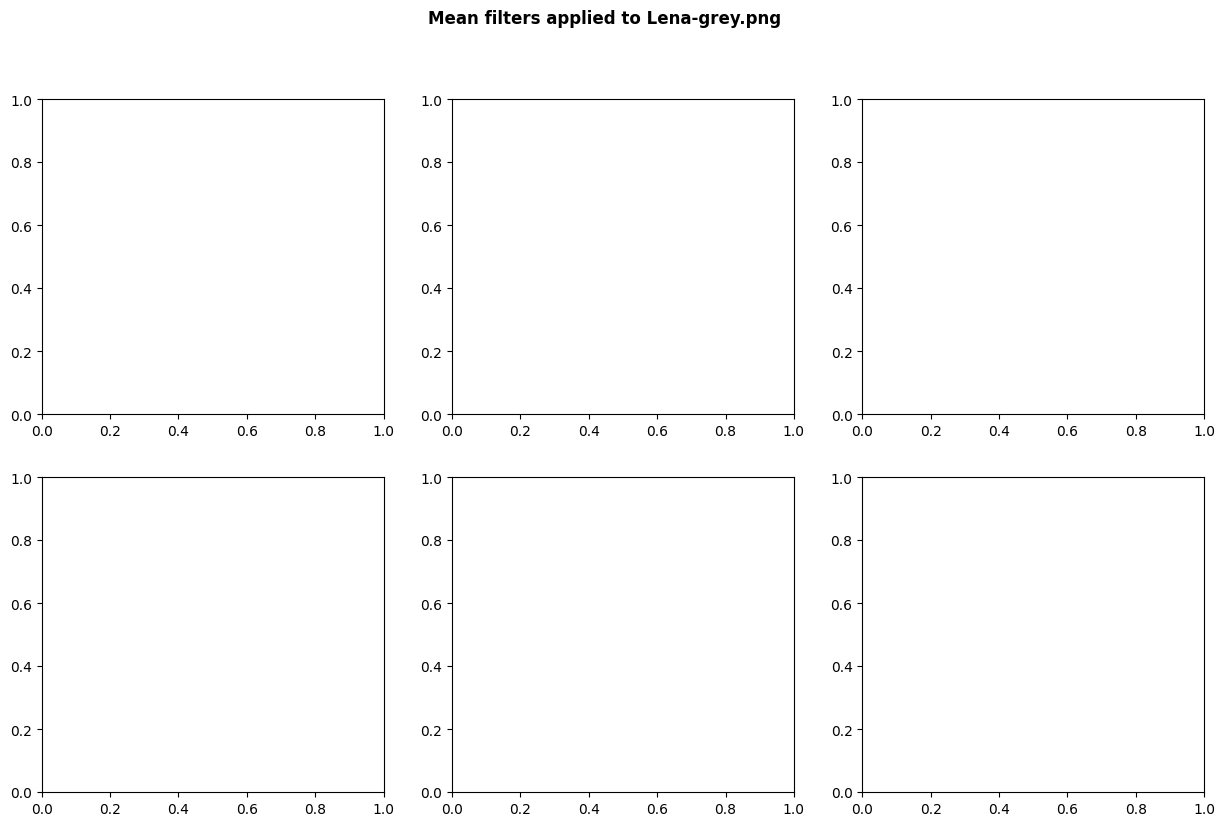

In [530]:
fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15,9))
fig.suptitle(f'Mean filters applied to {image_name}', fontweight='bold')

image_filetered_3 = filter_image(image, mean_3, PaddingType.EXTEND)
image_filetered_5 = filter_image(image, mean_5, PaddingType.EXTEND)
image_filetered_9 = filter_image(image, mean_9, PaddingType.EXTEND)

ax1[0].set_axis_off()
ax1[2].set_axis_off()

ax1[1].imshow(image, cmap='gray')
ax1[1].set_title('Original image')
ax1[1].set_axis_off()

ax2[0].imshow(image_filetered_3, cmap='gray')
ax2[0].set_title('3*3 mean filter')
ax2[0].set_axis_off()

ax2[1].imshow(image_filetered_5, cmap='gray')
ax2[1].set_title('5*5 mean filter')
ax2[1].set_axis_off()

ax2[2].imshow(image_filetered_9, cmap='gray')
ax2[2].set_title('9*9 mean filter')
ax2[2].set_axis_off()

## Now let's compare the 5*5 filter with the different padding types and discuss results

* First display some exemples of big border extensions

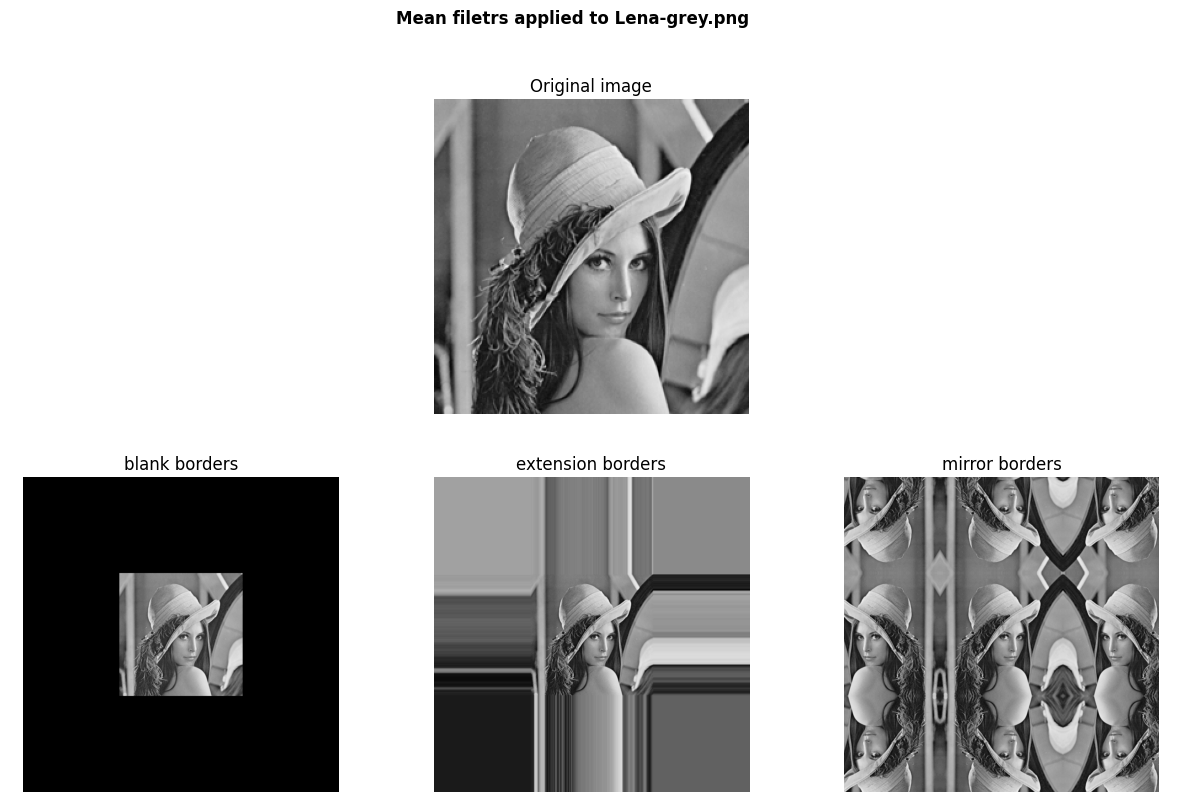

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15,9))
fig.suptitle(f'Mean filetrs applied to {image_name}', fontweight='bold')

w_ext, y_ext = 200, 200

#First line
ax1[0].set_axis_off()
ax1[2].set_axis_off()

ax1[1].imshow(image, cmap='gray')
ax1[1].set_title('Original image')
ax1[1].set_axis_off()

#Second line
ax2[0].imshow(extend_image_borders(image, PaddingType.BLANK, w_ext, y_ext), cmap='gray')
ax2[0].set_title('blank borders')
ax2[0].set_axis_off()

ax2[1].imshow(extend_image_borders(image, PaddingType.EXTEND, w_ext, y_ext), cmap='gray')
ax2[1].set_title('extension borders')
ax2[1].set_axis_off()

ax2[2].imshow(extend_image_borders(image, PaddingType.MIRROR, w_ext, y_ext), cmap='gray')
ax2[2].set_title('mirror borders')
ax2[2].set_axis_off()

* now observe the results of each on a rather big mean kernels 

In [ ]:
big_mean_kernel = create_mean_filter((11, 11))

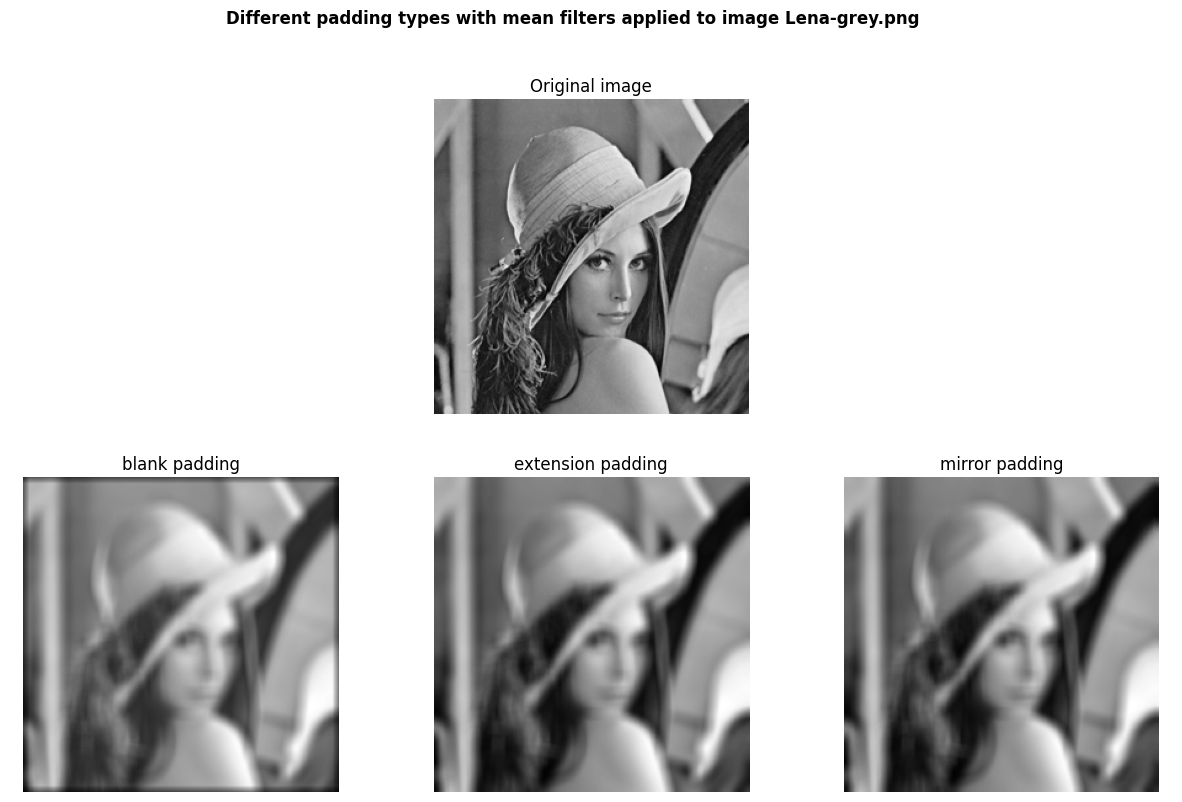

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15,9))
fig.suptitle(f'Different padding types with mean filters applied to image {image_name}', fontweight='bold')

big_mean_kernel = create_mean_filter((11,11))
image_filetered_blank = filter_image(image, big_mean_kernel, PaddingType.BLANK)
image_filetered_extended = filter_image(image, big_mean_kernel, PaddingType.EXTEND)
image_filetered_mirrored = filter_image(image, big_mean_kernel, PaddingType.MIRROR)

kernel_w, kernel_h = big_mean_kernel.shape
x_extension, y_extension = round((kernel_h-1)/2), round((kernel_w-1)/2)

#First line
ax1[0].set_axis_off()
ax1[2].set_axis_off()

ax1[1].imshow(image, cmap='gray')
ax1[1].set_title('Original image')
ax1[1].set_axis_off()

#Second line
ax2[0].imshow(image_filetered_blank, cmap='gray')
ax2[0].set_title('blank padding')
ax2[0].set_axis_off()

ax2[1].imshow(image_filetered_extended, cmap='gray')
ax2[1].set_title('extension padding')
ax2[1].set_axis_off()

ax2[2].imshow(image_filetered_mirrored, cmap='gray')
ax2[2].set_title('mirror padding')
ax2[2].set_axis_off()

# (c) Comment on the results obtained with the different filter sizes.

### Kernel size
The mean filters are more impactfull the bigger the kernels are: the resulting intensity is more and more dilluted.\
This results in a longer processing time and a more powerfull blur effect.\
This is a low-pass filter: The details (high-intensity signals) are lost and the resulting image becomes harder to see and tends to a single shade of grey.

### Padding type
The border extension of the images implemented in this notebook are blank / extended / mirrored. The figure 2 shows their effects.\
There is a clear effect of blank padding on images are it tends to add a black frame at the border as the blank pixels are black (intensity 0). Even on a mean filter of 11, the extended and mirror padding don't make a great difference on the pictures tested (Ara, Lena, Baboon).

# 2. Edge detection

## (a) Implement your own Laplacian of Gaussian filter (example provided in the lecture).

In [ ]:
#Lecture 'DIP-04 LocalOperations' p.24, Laplacian of Gaussian 5*5
laplacian_of_gaussian_kernel = np.array([
    [0,1, 1 ,1,0], 
    [1,3, 0 ,3,1], 
    [1,0,-24,0,1],
    [1,3, 0 ,3,1], 
    [0,1, 1 ,1,0]
])

## (b) Implement your own gradient filters for edge detection (examples for vertical and horizontal filters provided in the lecture).

In [ ]:
horiz_gradient_kernel = np.array([
    [0,0,0],
    [-1,0,1],
    [0,0,0]
])

vertical_gradient_kernel = np.array([
    [0,-1,0],
    [0,0,0],
    [0,1,0]
])

#2D equivalents of 1D because the implemented methods expects 2D kernels

## (c) Apply both edge detection methods to the greyscale images provided on ILIAS.

IndentationError: expected an indented block after function definition on line 1 (1957927991.py, line 1)

In [ ]:
def detect_edges(image_name):
    image = cv2.imread(f'./in/{image_name}', cv2.IMREAD_GRAYSCALE)

    laplacian_of_gaussian_result = filter_image(image, laplacian_of_gaussian_kernel, PaddingType.EXTEND)
    horiz_gradient_result = filter_image(image, horiz_gradient_kernel, PaddingType.EXTEND)
    vertical_gradient_result = filter_image(image, vertical_gradient_kernel, PaddingType.EXTEND)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(15,12))
    fig.suptitle(f'Detection kernels applied to image {image_name}', fontweight='bold')

    #First line
    ax1[0].set_axis_off()
    ax1[2].set_axis_off()

    ax1[1].imshow(image, cmap='gray')
    ax1[1].set_title('Original image')
    ax1[1].set_axis_off()

    #Second line
    ax2[0].imshow(horiz_gradient_result, cmap='gray')
    ax2[0].set_title('Horizontal gradient')
    ax2[0].set_axis_off()

    ax2[1].imshow(vertical_gradient_result, cmap='gray')
    ax2[1].set_title('Vertical gradient')
    ax2[1].set_axis_off()

    ax2[2].imshow(cv2.add(horiz_gradient_result,vertical_gradient_result), cmap='gray')
    ax2[2].set_title('Horizontal + Vertical gradient')
    ax2[2].set_axis_off()

    #Third line
    ax3[0].set_axis_off()

    ax3[1].imshow(laplacian_of_gaussian_result, cmap='gray')
    ax3[1].set_title('Laplacian of Gaussian')
    ax3[1].set_axis_off()
    
    ax3[2].set_axis_off()

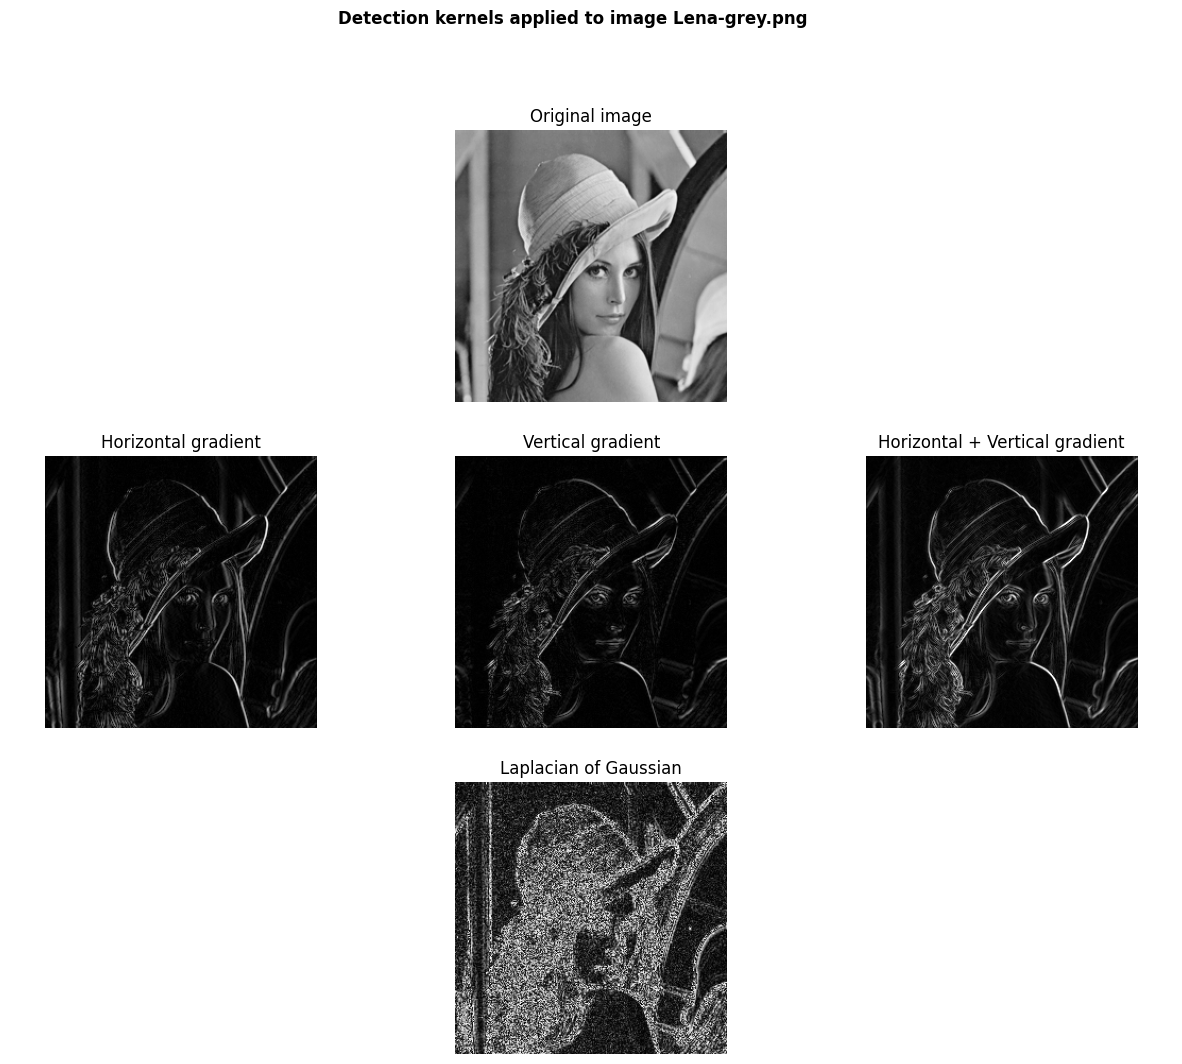

In [ ]:
detect_edges("Lena-grey.png")

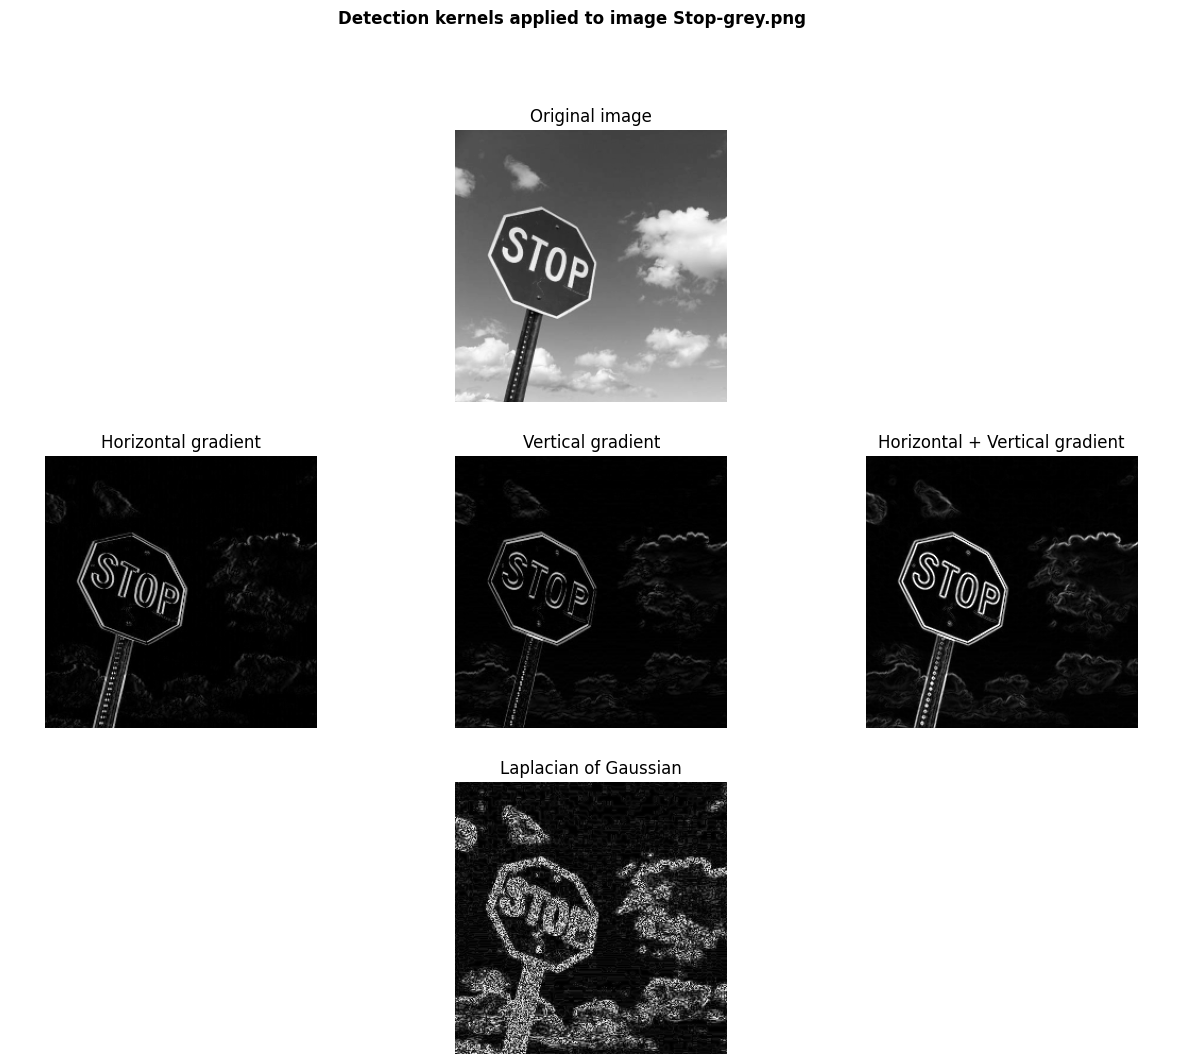

In [ ]:
detect_edges("Stop-grey.png")

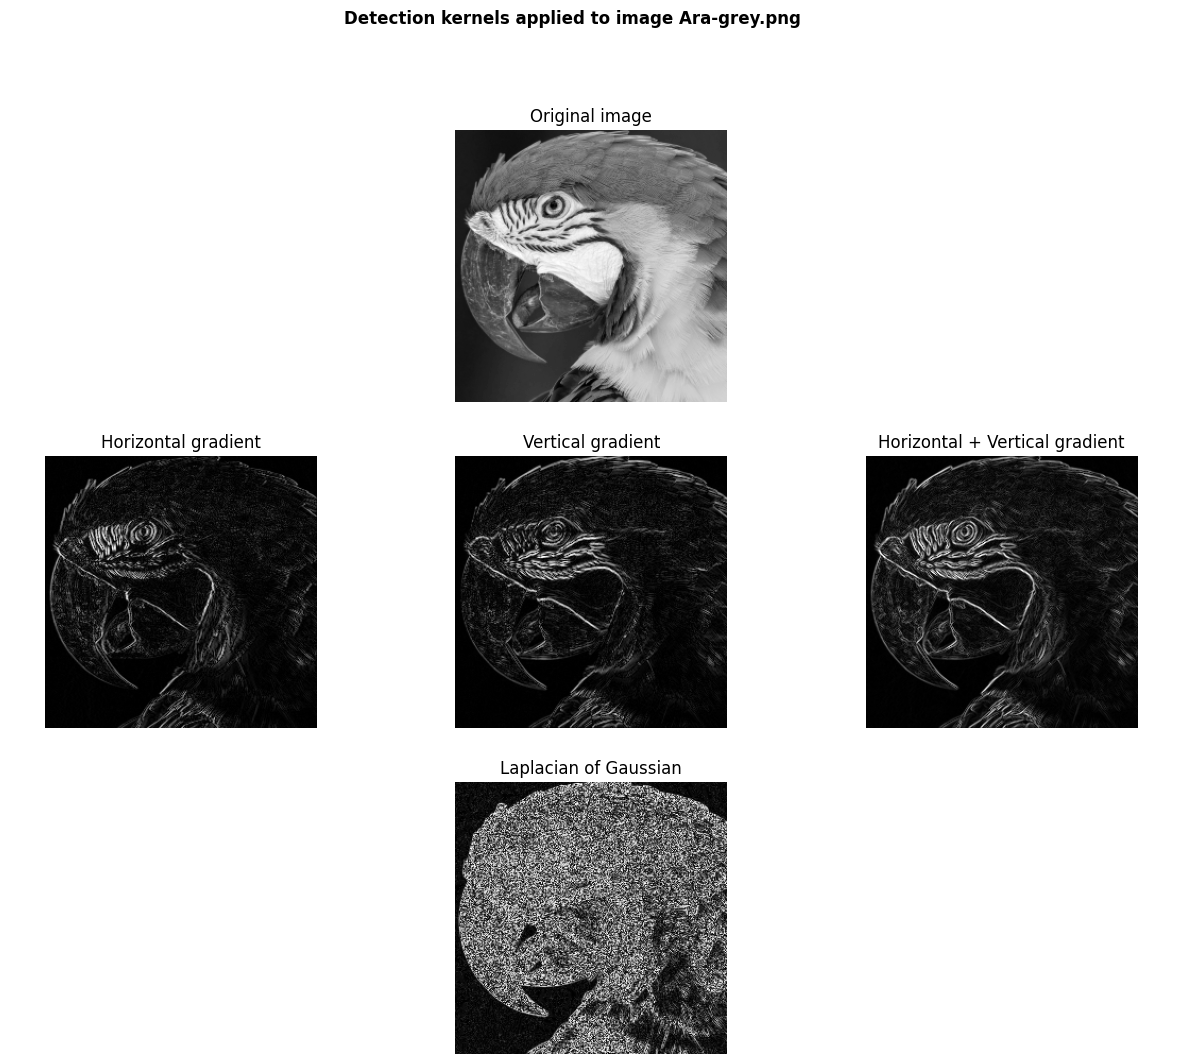

In [ ]:
detect_edges("Ara-grey.png")

## (d) Comment on the results obtained with the two methods.

* The gradient edge detection works in two steps that can be combined as shown above. The result is an image that has sharp lines and very precise edges around great changes in intensity.
* The Laplacian of Gaussian works in one step but has a bigger kernel - and the kernel used above is not he biggest one that can be computed. The filter's resulting image seems to separate the background in black from the principal shapes that are activated in white. 

The gradiant methods is done in vertical / horizontal steps, meaning they have a greatly reduced complexity if done right. If the Laplacian kernel is separable (it sure seems like it), both methods would be similar in complexity.\
The gradiant filters extract sharp edges (lines) separating objects whereas the Laplacian filter activates shapes that are filled - in order to have the same result, we would have to either apply a region mecanism for the gradiants or only take the edges for the Laplacian All in all, both produce great results and are already extracting most of the simple shapes of the three images tested (Lena, Stop, Ara)

# 3. Statistical filters
## (a) Implement your own minimum and maximum filters (formulas provided in the lecture), with size 3\*3 and 5\*5 pixels.

In [545]:

from typing import Callable


def rank_filter_image(image: Mat, stat_function: Callable, shape: shape, padding: PaddingType) -> Mat:
    """ Apply the given stat function to execute a rank filter on the image. Neighbooroods for the stat function are of the input shape. """
    x_extension, y_extension = round((shape[0]-1)/2), round((shape[1]-1)/2)
    #Pre-process: create a working version of the image that resolves the border problems easily (add pixels at borders)
    #This reduces code complexity but increases space complexity (not done in-place on the image in order to avoid loosing original matrix)
    extended_image = extend_image_borders(image, padding, x_extension, y_extension)

    #Resulting image does not need this border - the extended border is only used to avoid indetermined pixel during convol execution at borders
    result_image = np.zeros_like(image.transpose())

    #Transpose to work with x,y coordinates and not x,y
    transposed_extended_image = extended_image.transpose()

    #Apply convoluation to every pixel of the resulting image
    h, w = image.shape
    for x in range(w):
        for y in range(h):
            nb = neighboorhood(x+x_extension, y+y_extension, shape, transposed_extended_image)
            result_image[x,y] = stat_function(nb)

    #Transpose to work with y,x numpy coordinates and not human-logical x,y
    return result_image.transpose()

def neighboorhood(x: int, y: int, shape: shape, image: Mat) -> Mat:
    """Return the neighboorhood of at the given pixel with the given shape"""
    offset_x, offset_y = round((shape[0]-1)/2), round((shape[1]-1)/2)
    return image[x-offset_x : x+offset_x+1, y-offset_y : y+offset_y+1]

* Tests on min, max

In [546]:
image = np.array([[1,2,3], [1,2,3], [1,2,3]])
image_max = rank_filter_image(image, np.max, (3,3), PaddingType.EXTEND)
print(image_max)

image = np.array([[1,2,3], [1,2,3], [1,2,9]])
image_max = rank_filter_image(image, np.max, (5,5), PaddingType.EXTEND)
print(image_max)

[[2 3 3]
 [2 3 3]
 [2 3 3]]
[[9 9 9]
 [9 9 9]
 [9 9 9]]


In [547]:
image = np.array([[1,2,3], [1,2,3], [1,2,3]])
image_max = rank_filter_image(image, np.min, (3,3), PaddingType.EXTEND)
print(image_max)

image = np.array([[8,8,8], [9,9,9], [1,2,1]])
image_max = rank_filter_image(image, np.min, (5,5), PaddingType.EXTEND)
print(image_max)

[[1 1 2]
 [1 1 2]
 [1 1 2]]
[[1 1 1]
 [1 1 1]
 [1 1 1]]


## (b) Apply both filters to the greyscale images provided on ILIAS, as well as their combination (max - min).

In [555]:
def stat_filters(image_name: str, shape: shape):
    image = cv2.imread(f'./in/{image_name}', cv2.IMREAD_GRAYSCALE)

    image_max = rank_filter_image(image, np.max, shape, PaddingType.EXTEND)
    image_min = rank_filter_image(image, np.min, shape, PaddingType.EXTEND)
    image_max_min = cv2.subtract(image_max, image_min)

    fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15,9))
    fig.suptitle(f'Statistical filters applied to image {image_name} with a neighborhood of {shape}', fontweight='bold')

    ax1[0].set_axis_off()
    ax1[2].set_axis_off()

    ax1[1].imshow(image, cmap='gray')
    ax1[1].set_title('Original image')
    ax1[1].set_axis_off()

    ax2[0].imshow(image_max, cmap='gray')
    ax2[0].set_title('Max filter')
    ax2[0].set_axis_off()

    ax2[1].imshow(image_min, cmap='gray')
    ax2[1].set_title('Min filter')
    ax2[1].set_axis_off()

    ax2[2].imshow(image_max_min, cmap='gray')
    ax2[2].set_title('Max-Min filters')
    ax2[2].set_axis_off()

In [556]:
image_name = "Lena-grey.png"

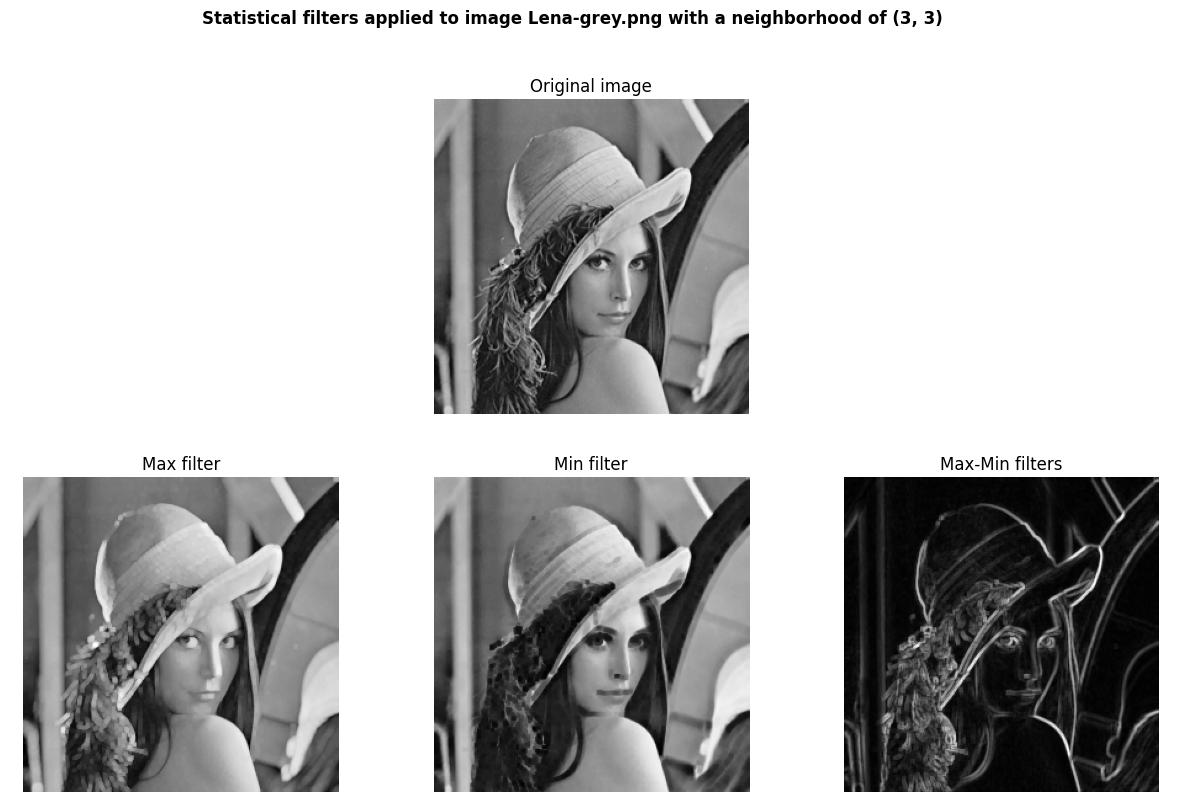

In [557]:
stat_filters(image_name, (3,3))

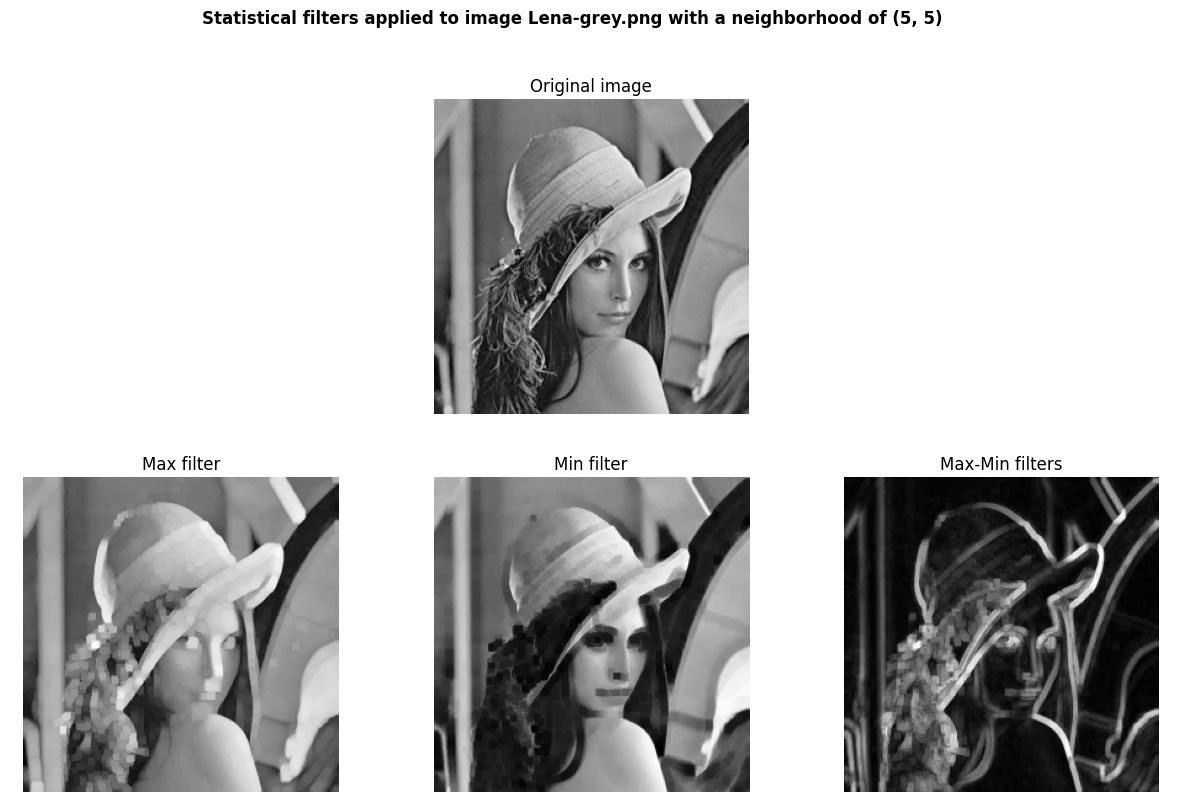

In [558]:
stat_filters(image_name, (5,5))

## (c) Comment on the results obtained with the individual filters and their combination.

## Max, Min, MaxMin

* Max filter: The max filter makes the image very white and thus exacerbate the intense parts of the image by making them multiple pixels wide, depending on the kernel size
* Min filter: Similarly, the image becomes black and the min filter exacerbates the low parts of the image by making them multiple pixel wide

In both cases, the homogenous parts of the image stay the same as a min/max has basically no effect. But every low-intensity region is amplified by the min and every high-intensity region is amplified by the max filter.

* Max - Min filter: The resulting image of Max - min is very similar to the Horizontal + Vertical addition of the gradient filter: It has sharp edges as high-intensity pixels.
    * Effectively, every homogenous part of the image is both in the max and min - and thus removed from the last image. Every part where there is a high max & low min or high min & low max is amplified - and every part that is changing from max to min and vice-versa is an edge.

## Neighbourood size
The neighbourood size testes are 3\*3 and 5\*5. Although the 3\*3 filter shows great results, the 5\*5 filter is lacking in the sense that has a blurring effect. This could be because the min/max neighbourood being too great displaces the min/max values too far out of their regions. The resulting Max-Min image is also blurred and the edges are less sharp and ill defined.